In [40]:
import shutil

# importing the sys module
import sys        

# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime


import diff_pipeline4__config_diff_infer as cfg

from diff_pipeline4__dataset import DiffPipeline4SameUniformDiffDataset, DiffPipeline4MixedUniformDiffDataset, DiffPipeline4MimicDiffDataset, get_error_constrained_dataset


from Common.Datasets.Morph2.data_parser import DataParser
from Common.Datasets.Morph2.Morph2ClassifierDataset3 import Morph2ClassifierDataset3
from diff_pipeline4__train import train_diff_cls_model_iter


from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler


from diff_pipeline4__model import DiffPipeline4Model, DiffPipeline4DeepModel, AgeDiffModel, DiffModelConfigType

from Common.Pipelines.AgePredictBasicPipeline import AgePredictBasicPipeline, AgePredictOriginalPipeline
from Common.Pipelines.AgePredictSingleRefPipeline import AgePredictSingleRefEnhancedPipeline
from Common.Analysis.DiffAnalysisMethods import diff_pipeline_confusion_matrix_analysis
from Common.Analysis.RegAnalysisMethods import reg_pipeline_mae_and_hist_analysis


from tqdm import tqdm


from Common.Models.UnifiedClassificaionAndRegressionAgeModel import UnifiedClassificaionAndRegressionAgeModel
from Common.Models.transformer import *
from Common.Models.unified_transformer_model import AgeTransformer

from sklearn import utils

if __name__ == "__main__":

    torch.manual_seed(cfg.RANDOM_SEED)
    np.random.seed(cfg.RANDOM_SEED)
    random.seed(cfg.RANDOM_SEED)

    if cfg.USE_GPU:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")

    print(device)

    torch.cuda.empty_cache()





    # Load data
    data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
    data_parser.initialize_data()

    x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
    if cfg.RANDOM_SPLIT:
        all_images = np.concatenate((x_train, x_test), axis=0)
        all_labels = np.concatenate((y_train, y_test), axis=0)

        x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)

    
    face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)
#     import pdb
#     pdb.set_trace()
    #face2emb_arr_trn_r = face2emb_arr_trn_r.item()
    
    face2emb_arr_vld_r = np.load('face2emb_arr_vld.npy', allow_pickle=True)
    #face2emb_arr_vld_r = face2emb_arr_vld_r.item()
    
    # shuffle basic aligned test
    # x_test_shuffled
    # y_test_shuffled


    with open("im2age_map_test.json", 'r') as im2age_map_test_f:
        im2age_map_test = json.load(im2age_map_test_f)
        
        
    trans = transforms.Compose([
            transforms.RandomResizedCrop(224, (0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.1
            )], p=0.5),
            transforms.RandomApply([transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                shear=5,
                resample=Image.BICUBIC
            )], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.5)
        ])
        
    train_ds = Morph2ClassifierDataset3(
        x_train,
        y_train,
        cfg.MIN_AGE,
        cfg.AGE_INTERVAL,
        trans,
        copies=cfg.NUM_OF_COPIES_AGE_PREDICT
    )
    
    test_ds = Morph2ClassifierDataset3( #Morph2ClassifierDataset Morph2ClassifierDataset2
        x_test,
        y_test,
        cfg.MIN_AGE,
        cfg.AGE_INTERVAL,
        transform=transforms.Compose([
            transforms.RandomResizedCrop(224, (0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.1
            )], p=0.5),
            transforms.RandomApply([transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                shear=5,
                resample=Image.BICUBIC
            )], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.5)
        ]),
        copies=cfg.NUM_OF_COPIES_AGE_PREDICT
    )
    
    data_loaders = {
        'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False, drop_last=False),
        'val': DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False, drop_last=True)
    }
    
    num_classes = int((cfg.MAX_AGE - cfg.MIN_AGE) / cfg.AGE_INTERVAL + 1)


    pipeline = AgePredictOriginalPipeline(
                    device=device,
                    num_classes=num_classes, 
                    age_interval=cfg.AGE_INTERVAL, 
                    min_age=cfg.MIN_AGE,
                    max_age=cfg.MAX_AGE,
                    age_radius=cfg.AGE_RADIUS,
                    mid_feature_size=cfg.MID_FEATURE_SIZE_AGE_PREDICT, 
                    images_train_db=x_train,
                    metadata=y_train,
                    deep=False, 
                    num_references=0, 
                    config_type=0, 
                    added_embed_layer_size=0, 
                    diff_embed_layer_size=0,
                    transform=trans,
                    copies=cfg.NUM_OF_COPIES_AGE_PREDICT,
                    unified_model=UnifiedClassificaionAndRegressionAgeModel,
                    transformer_model=TransformerModel,
                    age_transformer=AgeTransformer,
                    is_round=False,
                    cfg=cfg)

cuda:0


C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torchvision\transforms\transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Using multiple GPUs (2)


# Checking Whether Model Error & Logits STD Are Related

In [41]:
from tqdm import tqdm

In [42]:
i = 0
#err_vec = []
im2err_map = dict()
im2logits_map = dict()
for batch in tqdm(data_loaders['val']):
    inputs = batch['image'].to(device)
    ages = batch['age'].to(device).float()
    idxs = batch['idx'].to(device).float()

    with torch.no_grad():
        cls_logits, age_pred = pipeline.predict(inputs, with_logits=True)#, bypass_diff=True, check_ranges=False)

    errs = age_pred - ages
    
    for j in range(len(idxs)):
        im2err_map[int(idxs[j].cpu())] = float(age_pred[j].cpu())-float(ages[j].cpu())
        im2logits_map[int(idxs[j].cpu())] = cls_logits[j].cpu().numpy()
        
    i += 1
    
#     if i == 5:
#         break
    
    #err_vec += errs.cpu().numpy().tolist()


  0%|                                                                                          | 0/165 [00:00<?, ?it/s]D:\projects\age_estimation\DiffPipeline4\..\Common\Models\transformer.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = nn.Softmax()(classification_logits)
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [03:05<00:00,  1.13s/it]


In [43]:
import matplotlib.pyplot as plt

In [44]:
len(im2logits_map)

10560

In [45]:
#im2err_map
pred_std = []
err = []
for i in range(len(im2logits_map)):
    pred_std.append(np.std(nn.Softmax()(torch.Tensor(im2logits_map[i])).numpy()))
    err.append(im2err_map[i])

C:\Users\proj\AppData\Local\Temp\ipykernel_13708\3243018323.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_std.append(np.std(nn.Softmax()(torch.Tensor(im2logits_map[i])).numpy()))


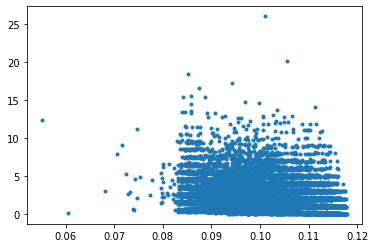

In [47]:
plt.plot(pred_std, np.abs(err), '.')

In [48]:
my_rho = np.corrcoef(pred_std, np.abs(err))

print(my_rho)

[[ 1.         -0.14554478]
 [-0.14554478  1.        ]]


In [27]:
im2err_map[10]

-5.118865966796875

In [ ]:
#reg_pipeline_mae_and_hist_analysis(pipeline=pipeline, data_loader=data_loaders['train'], device=device, dataset_size=len(train_ds), dataset_type="train", pipeline_is_model=False)


In [ ]:
#18.2335/64
#len(train_ds)

In [ ]:
with open("im2age_map_train.json", 'r') as im2age_map_train_f:
    im2age_map_train = json.load(im2age_map_train_f)

# Methods

In [50]:
def get_ages(y_ds):
    return np.array([int(json.loads(metadata)['age']) for metadata in y_ds])

In [51]:
def draw_hist(y_ds, bins):
    ages = get_ages(y_ds)
    plt.hist(ages, bins=bins)

In [52]:
def draw_err_hist(y_ds, im2age_map, bins):
    err = []
    ages = get_ages(y_ds)
    for i in range(len(im2age_map)):
        err.append(ages[i] - im2age_map[str(i)])
    plt.hist(err, bins=bins)

In [53]:
def calc_ages2preds(y_ds, im2age_map):
    ages = get_ages(y_ds)
    ages2preds = dict()
    for i in range(len(ages)):
        age_real = ages[i]
        age_pred = im2age_map[str(i)]
        if age_real in ages2preds:
            ages2preds[age_real].append(age_pred)
        else:
            ages2preds[age_real] = [age_pred]
        
    return ages2preds

In [54]:
def calc_ages2meanerr(ages2pred):
    ages2meanerr = dict()
    for age_real in ages2pred.keys():
        ages2meanerr[age_real] = np.mean(np.abs(np.array(ages2pred[age_real])-age_real))
        
    return ages2meanerr

In [55]:
def calc_ages2errdist(ages2pred):
    ages2meanerr = dict()
    for age_real in ages2pred.keys():
        errs = np.array(ages2pred[age_real])-age_real
        #ages2meanerr[age_real] = [np.mean(np.abs(errs)), np.std(errs), min(errs), max(errs)]
        ages2meanerr[age_real] = [np.mean(errs), np.std(errs), min(errs), max(errs)]
        
    return ages2meanerr

In [56]:
def get_query_age_2_err_desc(y_ds, im2age_map):
    query_age_2_err_desc = dict()
    ages = get_ages(y_ds)
    for i in range(len(ages)):
        age_real = ages[i]
        age_pred = int(np.round(im2age_map[str(i)]))
        err_abs = np.abs(age_real-age_pred)
        if age_real not in query_age_2_err_desc:
            query_age_2_err_desc[age_real] = {
                "total_samples" : 0,
                "range4up_samples" : 0,
                "range03_samples" : 0
            }
        query_age_2_err_desc[age_real]["total_samples"] += 1
        if err_abs > 3:
            query_age_2_err_desc[age_real]["range4up_samples"] += 1
        else:
            query_age_2_err_desc[age_real]["range03_samples"] += 1

    return query_age_2_err_desc

In [57]:
def get_query_age_2_err_4up_rate(query_age_2_err_desc):
    query_age_2_err_4up_rate = dict()
    for age in query_age_2_err_desc.keys():
        query_age_2_err_4up_rate[age] = query_age_2_err_desc[age]["range4up_samples"] / query_age_2_err_desc[age]["total_samples"]
    return query_age_2_err_4up_rate

In [58]:
def check_num_of_samples_err_4up_from_age(query_age_2_err_desc, start_age):
    total_relevant_samples = 0
    for age in query_age_2_err_desc.keys():
        if age >= start_age:
            total_relevant_samples += query_age_2_err_desc[age]["range4up_samples"]
    return total_relevant_samples

In [59]:
def plot_4up_rate(query_age_2_err_4up_rate):
    sorted_tst_ages = np.sort(list(query_age_2_err_4up_rate.keys()))
    plt.plot(sorted_tst_ages, [query_age_2_err_4up_rate[age] for age in sorted_tst_ages])

In [60]:
def verify_ds(im2age_map):
    l = []
    for k in im2age_map.keys():
        l.append(int(k))
    l_sorted = np.sort(l)

    #len(im2age_map_test)
    acc_d = 0
    for i in range(len(im2age_map)):
        if l_sorted[i-acc_d] != i:
            print(i)
            acc_d += 1

# Training Set Analysis

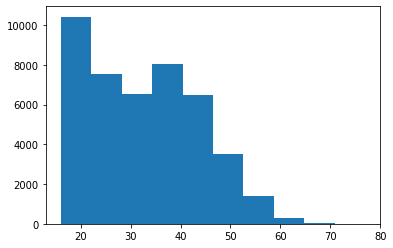

In [62]:
draw_hist(y_train, 10)

In [63]:
draw_err_hist(y_train, im2age_map_train, 1000)

NameError: name 'im2age_map_train' is not defined

In [64]:
trn_query_age_2_err_desc = get_query_age_2_err_desc(y_train, im2age_map_train)
trn_query_age_2_err_4up_rate = get_query_age_2_err_4up_rate(trn_query_age_2_err_desc)

NameError: name 'im2age_map_train' is not defined

In [ ]:
plot_4up_rate(trn_query_age_2_err_4up_rate)

# Testing Set Analysis

In [65]:
verify_ds(im2age_map_test)

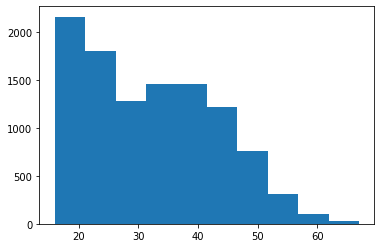

In [66]:
draw_hist(y_test, 10)

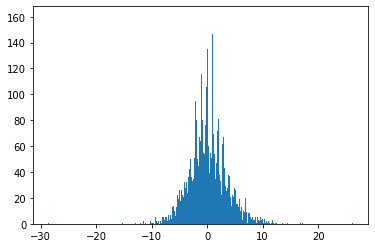

In [67]:
draw_err_hist(y_test, im2age_map_test, 1000)

In [68]:
tst_query_age_2_err_desc = get_query_age_2_err_desc(y_test, im2age_map_test)
tst_query_age_2_err_4up_rate = get_query_age_2_err_4up_rate(tst_query_age_2_err_desc)

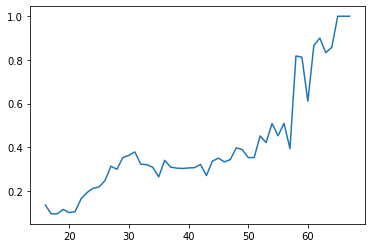

In [69]:
plot_4up_rate(tst_query_age_2_err_4up_rate)

# Draft

In [ ]:
ages2preds = calc_ages2preds(test_ages, im2age_map_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(ages2preds[17])

In [ ]:
plt.hist(ages2preds[25])

In [ ]:
plt.hist(ages2preds[35])

In [ ]:
0plt.hist(ages2preds[54])#, bins=20)

In [ ]:
plt.hist(ages2preds[40])

In [ ]:
plt.hist(ages2preds[70])

In [ ]:
ages2meandist = calc_ages2errdist(ages2preds)

In [ ]:
ages2meandist

In [ ]:
sorted_tst_ages = np.sort(list(ages2meanerr.keys()))

In [ ]:
for age in sorted_tst_ages:
    print(age, " : ", ages2meanerr[age])

In [ ]:
plt.plot(sorted_tst_ages, [ages2meanerr[age] for age in sorted_tst_ages])

In [ ]:
len(test_ages)

In [ ]:
sorted_tst_ages = np.sort(list(query_age_2_err_4up_rate.keys()))

In [ ]:
plt.plot(sorted_tst_ages, [query_age_2_err_4up_rate[age] for age in sorted_tst_ages])

In [ ]:
len(test_ages[test_ages > 40])

In [ ]:
check_num_of_samples_err_4up_from_age(40)

In [ ]:
train_ages = np.array([int(json.loads(metadata_for_image)['age']) for metadata_for_image in y_train])

In [ ]:
plt.hist(train_ages)

In [ ]:
len(train_ages[train_ages > 30])

In [ ]:
plt.hist(error, bins=100)

In [ ]:
len(error[np.abs(error) > 7])